## Projekt - BigData

#### Chojnacki Mateusz
---

### Opis danych

Dane zostały pobrane ze strony keggle : https://www.kaggle.com/datasets/christovitohidajat/car-data

Zawierają one dane na temat używanych samochodów używanych
Zawierają takie informacje jak :
- Brand : Marka pojazdu typu np. BMW, AUDI ...
- Price : Cena pojazdu
- Body : Typ auta np. sedan, van ...
- Mileage : Przebieg auta
- EngineV : Pojemność silnika
- Engine Type : Typ silnika
- Registration : Czy samochód jest zarejestrowany (yes/no)
- Year : Rok produkcji
- Model : Model producenta np. Q7 (dla audi), rav 4 (dla toyota)

Plik zawiera 4345 wierszy danych odnośnie powyższych zmiennych.

---

### Cel projektu

Projekt ma na celu przewidywać cenę używanych samochodów za pomocą różnych cech, takich jak marka, cena, przebieg, rodzaj paliwa, rok itp.

Taka możliwość przewidywania wartości rynkowej używanych samochodów może pomóc zarówno kupującym, jak i sprzedającym.

Istnieje wiele osób, które w pewnym momencie swojego życia chcą kupić lub sprzedać swoje auto. W tym procesie jest duże ryzyko zapłacenie za dużo lub sprzedanie za mało swojego auta.

Na początkowym etapie tego projektu skupimy się na analizie danych które są zawarte w naszym pliku. A na samym końcu przeprowadzimy dopasowanie do modeli oraz wybranie najbardziej odpowiedniego którymi oszacujemy wartość rynkową dla danego auta.

---

---

### Załadowanie potrzebnych bibliotek

In [848]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

orange = sns.color_palette(["#FFA07A"])
sns.set_palette(orange)
sns.set_style('whitegrid')

### Wczytywanie danych oraz wstępna analiza

In [849]:
car_data = pd.read_csv("car_data.csv")

In [850]:
car_data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.00,sedan,277,2.00,Petrol,yes,1991,320
1,Mercedes-Benz,7900.00,van,427,2.90,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.00,sedan,358,5.00,Gas,yes,2003,S 500
3,Audi,23000.00,crossover,240,4.20,Petrol,yes,2007,Q7
4,Toyota,18300.00,crossover,120,2.00,Petrol,yes,2011,Rav 4


In [851]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4345 entries, 0 to 4344
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         4345 non-null   object 
 1   Price         4173 non-null   float64
 2   Body          4345 non-null   object 
 3   Mileage       4345 non-null   int64  
 4   EngineV       4195 non-null   float64
 5   Engine Type   4345 non-null   object 
 6   Registration  4345 non-null   object 
 7   Year          4345 non-null   int64  
 8   Model         4345 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 305.6+ KB


Wyrzucamy kolumnę 'model'

In [852]:
df_raw = car_data.drop(labels='Model', axis=1)

Sprawdzamy czy występują braki danych w poszczególnych kolumnach

In [853]:
df_raw.isna().sum()

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
dtype: int64

Jak widzimy występują braki danych w kolumnach Price oraz EngineV

Wyrzucamy rekordy z brakującymi danymi :

In [854]:
df = df_raw.dropna()

In [855]:
df.isna().sum()

Brand           0
Price           0
Body            0
Mileage         0
EngineV         0
Engine Type     0
Registration    0
Year            0
dtype: int64

---

### Przegląd danych

#### Rozkład
Sprawdzimy jak wygląda rozkład prawdopodobieństwa, ułatwi to przegląd danych oraz znalezienie wartoścu odstających, zmienne :
- Price

Text(0.5, 1.0, 'Car Price Distribution Plot')

<Figure size 1100x500 with 0 Axes>

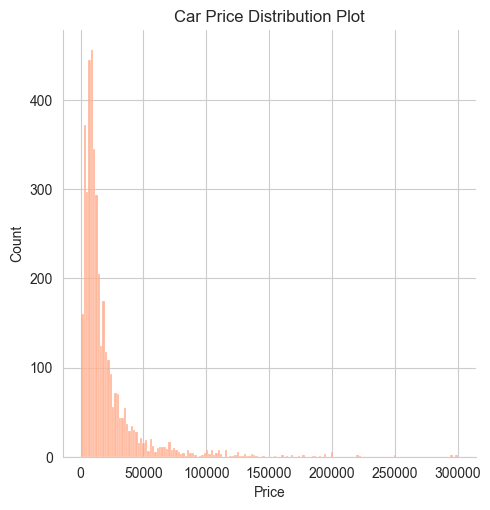

In [856]:
plt.figure(figsize=[11,5])
sns.displot(df['Price'])
plt.title('Car Price Distribution Plot')

Jak widzimy większość cen zawiera się w przedziale do 25 tyś, później zachodzi wielki spadek. Są również niewielkie wartości odstające w okolicach 300 tyś.

- Year

Text(0.5, 1.0, 'Car Year Distribution Plot')

<Figure size 1700x500 with 0 Axes>

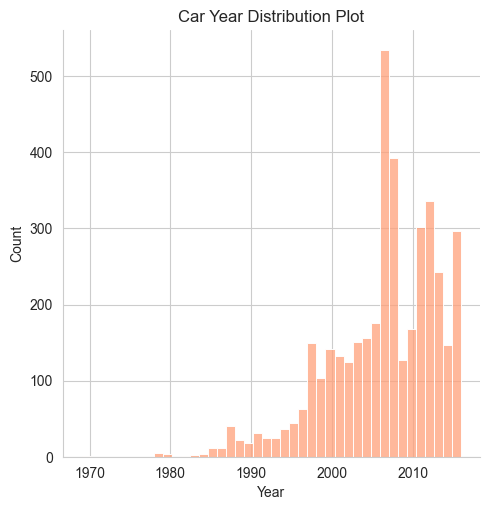

In [857]:
plt.figure(figsize=[17,5])
sns.displot(df['Year'])
plt.title('Car Year Distribution Plot')

Widzimy że większość aut została wyprodukowanych po 2000 roku. Są równiez przypadki gdzie rok produkcji wynosi około 1979 rok.

- Mileage

Text(0.5, 1.0, 'Car Mileage Distribution Plot')

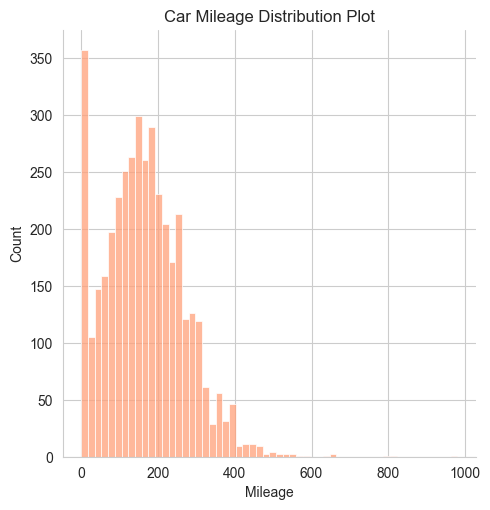

In [858]:
sns.displot(df['Mileage'])
plt.title('Car Mileage Distribution Plot')

Przebieg aut oscyluje do około 300 tyś, następnie zachodzi spadek. Występują również wartości odstające przekraczające 600 tyś.

- EngineV

Text(0.5, 1.0, 'EngineV Distribution Plot')

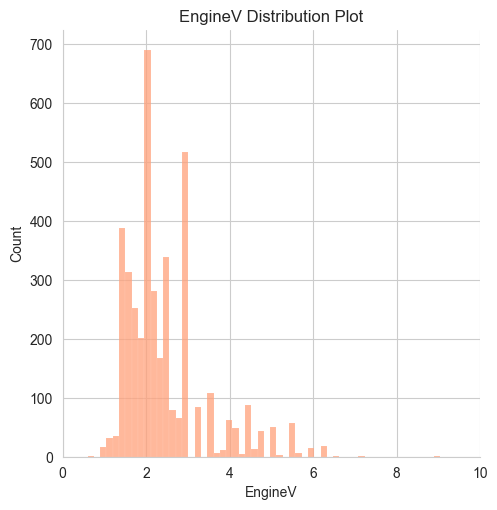

In [859]:
sns.displot(df['EngineV'])
plt.xlim(0,10)
plt.title('EngineV Distribution Plot')

Dla pojemności silnika widzimy że większość to okolice 2.0 ale również występują irracjonalne wartości odstające jak 9.0

---

### Wartości odstające

Jak w powyższym etapie zostały sprawdzone wizualnie czy występują wartości odstające, a w naszym przypadku istnieją należy dla lepszego dopasowania i precyzji modelu zająć się tymi odstającymi danymi.

Wartości odstające znajdują się zazwyczaj wokół wyższych cen (prawa strona wykresów) w naszym przypadku.

Łatwo poradzimy sobie z problemem usuwając 0,5% lub 1% problematycznych próbek.

To jest zbiór danych o używanych samochodach, więc można sobie wyobrazić, że 300 000 $ to wygórowana cena jak za używkę.

In [860]:
# Deklarujemy zmienną która będzie równa 99. percentylowi zmiennej "Price".
q = df['Price'].quantile(0.99)

# Następnie możemy utworzyć nowy df, pod warunkiem, że wszystkie ceny muszą być poniżej 99 percentyla „Price” -->
df_1 = df[df['Price']<q]

Text(0.5, 1.0, 'Car Price Distribution Plot')

<Figure size 1100x500 with 0 Axes>

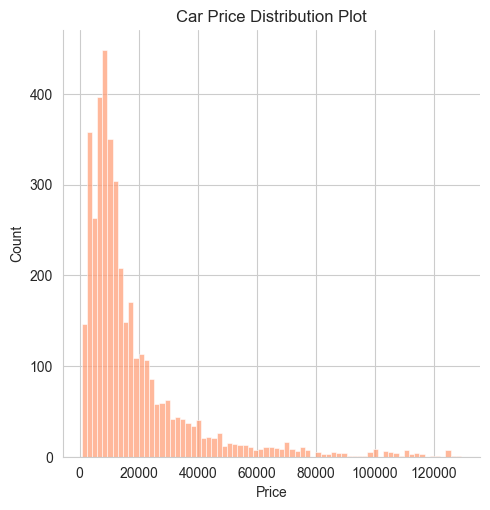

In [861]:
plt.figure(figsize=[11,5])
sns.displot(df_1['Price'])
plt.title('Car Price Distribution Plot')

Widzimy znaczącą przewagę nad wcześniejszym rozkładem.

Przeprowadzimy to również dla innych zmiennych.

In [862]:
q = df_1['Mileage'].quantile(0.99)
df_2 = df_1[df_1['Mileage']<q]

q = df_2['Year'].quantile(0.01)
df_3 = df_2[df_2['Year']>q]

In [863]:
# W ostatanim przypadku czyli pojemność silnika, zazwyczaj silnik jest poniżej 6,5 l. W dzisijszych czasach najczęsciej są to silniki od 1.6 do 2.5 l.
# Dlatego też w tym przypadku nie wystarczy ograniczyć zbioru jak wyżej. Trzeba znacznie bardziej go ograniczyć.
# Dlatego zbiór zostanie ograniczony tak aby nie występowały w nim wartości powyżej 6.5 l

df_4 = df_3[df_3['EngineV']<6.5]

#### Sprawdzenie poprawionych danych dla rozkładów

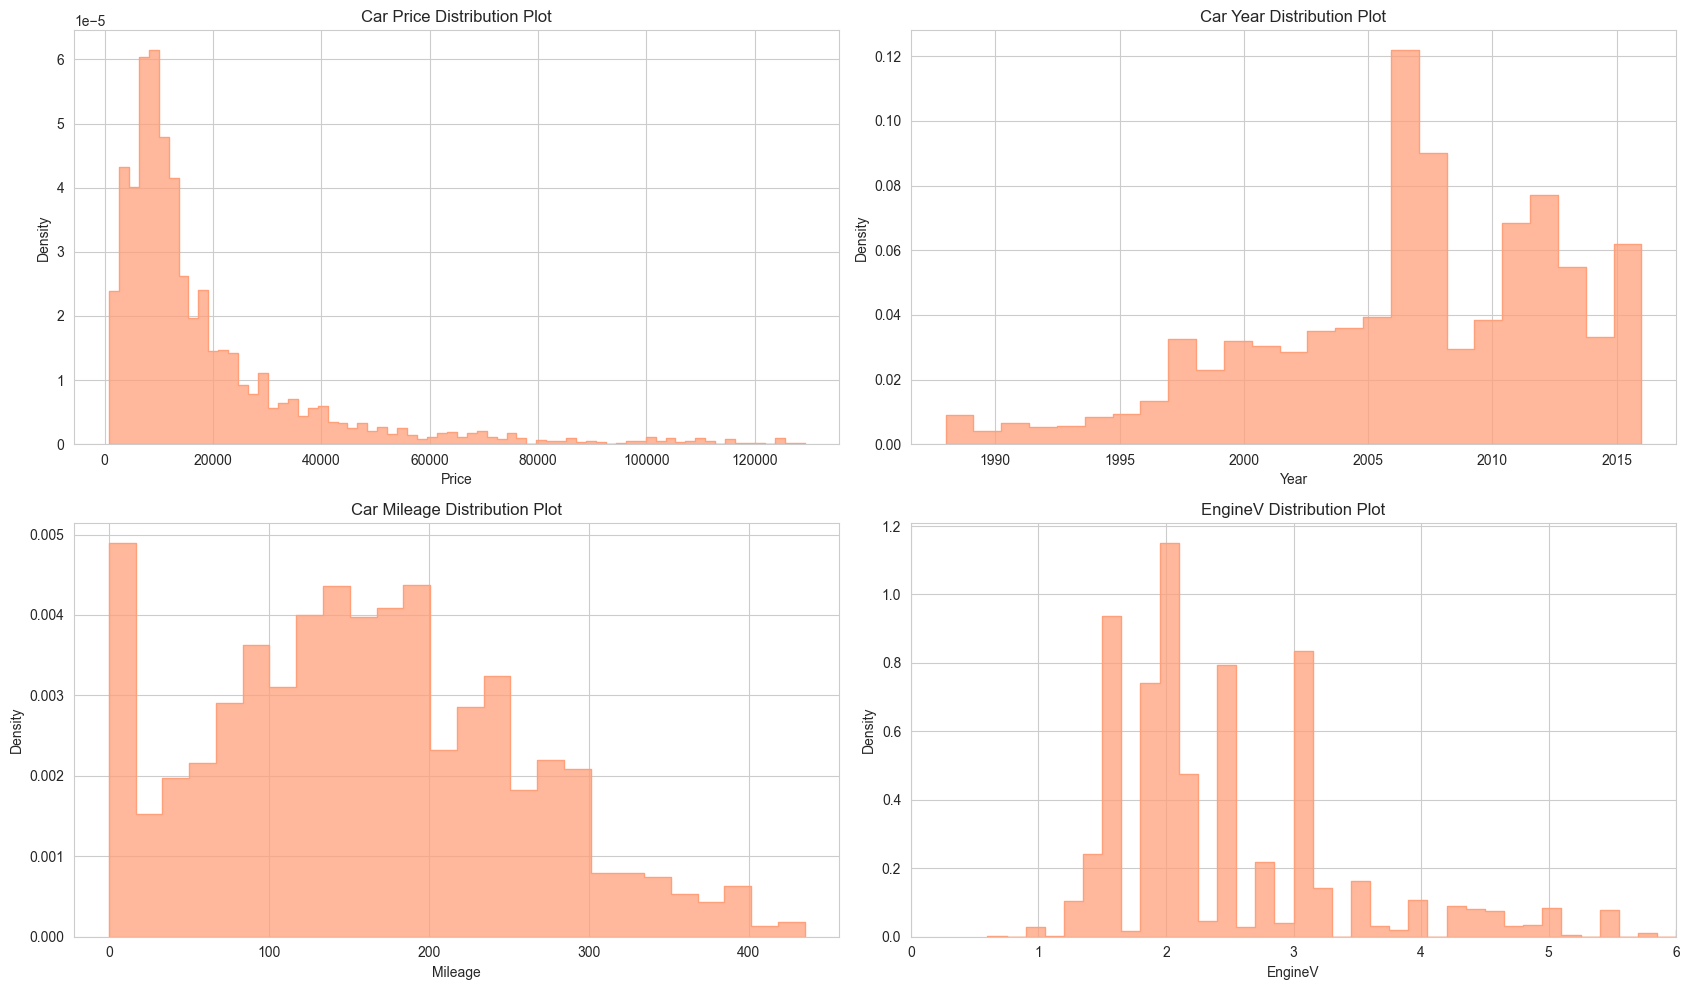

In [864]:
fig, axs = plt.subplots(2,2,figsize=(17,10))
sns.histplot(data=df_4, x='Price', element='step', stat='density', common_norm=False,ax=axs[0,0])
axs[0,0].set_title('Car Price Distribution Plot')

sns.histplot(data=df_4, x='Year', element='step', stat='density', common_norm=False,ax=axs[0,1])
axs[0,1].set_title('Car Year Distribution Plot')

sns.histplot(data=df_4, x='Mileage', element='step', stat='density', common_norm=False,ax=axs[1,0])
axs[1,0].set_title('Car Mileage Distribution Plot')

sns.histplot(data=df_4, x='EngineV', element='step', stat='density', common_norm=False,ax=axs[1,1])
axs[1,1].set_xlim(0,6.0)
axs[1,1].set_title('EngineV Distribution Plot')

plt.tight_layout()


Widzimy że teraz rozkład wygląda o wiele lepiej, nie występuje dużo wartości odstających.

---

### Statystyka

In [865]:
df_main = df_4.reset_index(drop=True)

In [866]:
df_main.describe()

,Price,Mileage,EngineV,Year
count,3867.00,3867.00,3867.00,3867.00
mean,18194.46,160.54,2.45,2006.71
std,19085.86,95.63,0.95,6.10
min,800.00,0.00,0.60,1988.00
25%,7200.00,91.00,1.80,2003.00
50%,11700.00,157.00,2.20,2008.00
75%,21700.00,225.00,3.00,2012.00
max,129222.00,435.00,6.30,2016.00


Powyższa statystyka informuje nas :
- liczebność jest taka sama w każdej kolumnie
- średnie wartości dla każdej kolumny np widzimy że średnia pojemność silnika to 2.38
- kolejne to są odchylenia standardowe, min max wartość, oraz przedziały ufności

#### Teraz sprawdzimy liniowość za pomocą wykresu punktowego

Text(0.5, 1.0, 'Price and EngineV')

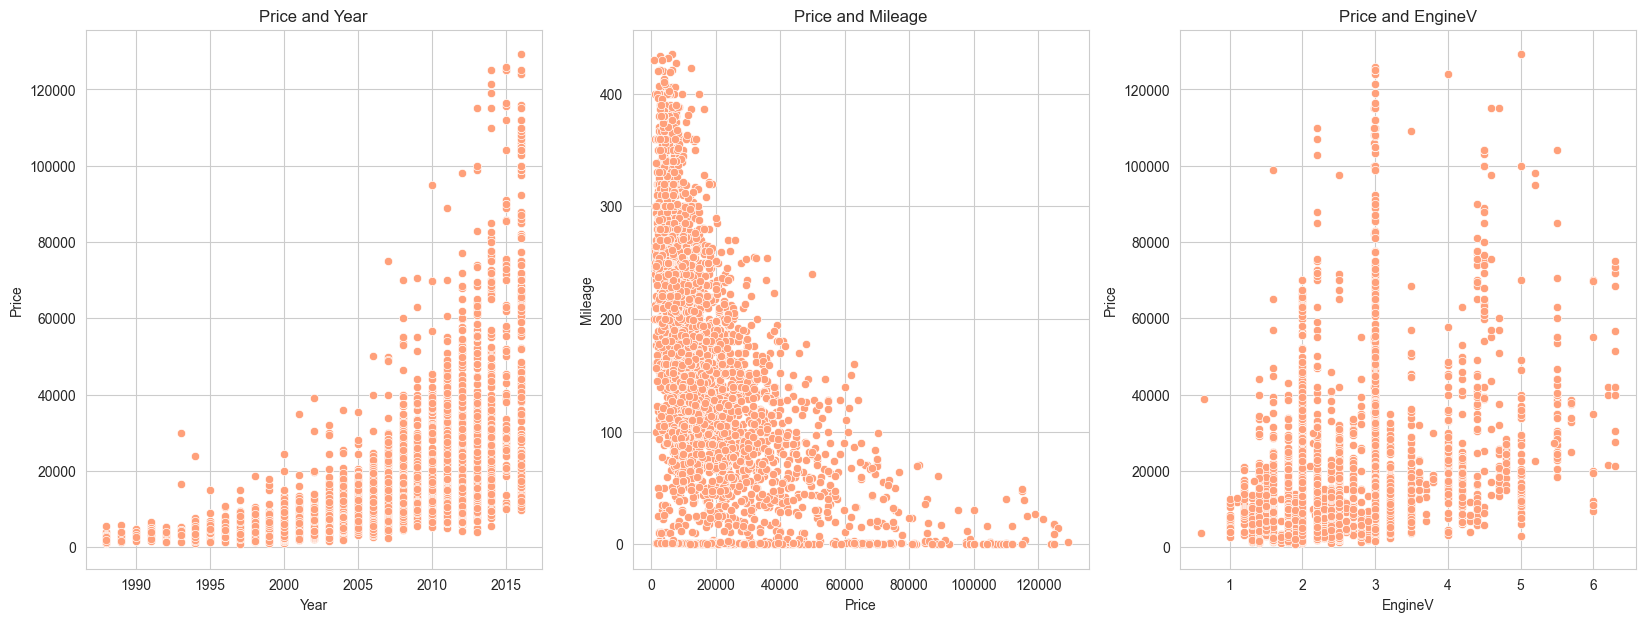

In [867]:
#Scatter Plot
plt.figure(figsize=[20,7])
plt.subplot(1,3,1)
plt.title("Price and Year")
sns.scatterplot(x='Year',y='Price',data=df_main)

plt.subplot(1,3,2)
plt.title("Price and Mileage")
sns.scatterplot(x='Price',y='Mileage',data=df_main)

plt.subplot(1,3,3)
sns.scatterplot(y='Price',x='EngineV',data=df_main)
plt.title("Price and EngineV")

Na podstawie wykresów rozkładu dla różnych zmiennych, można zauważyć, że wzorzec w danych nie jest idealnie liniowy. Dlatego model regresji liniowej nie jest odpowiedni dla tego zestawu danych. Dodatkowo zauważono, że zmienna cena nie jest rozłożona normalnie, a związek między ceną a innymi zmiennymi, które są bardziej normalnie rozłożone, nie jest liniowy. To sugeruje, że potrzebna jest jakaś forma transformacji lub metoda modelowania nieliniowego, aby skutecznie zmodelować związek między tymi zmiennymi.

Text(0.5, 1.0, 'Car Price Distribution Plot')

<Figure size 1100x500 with 0 Axes>

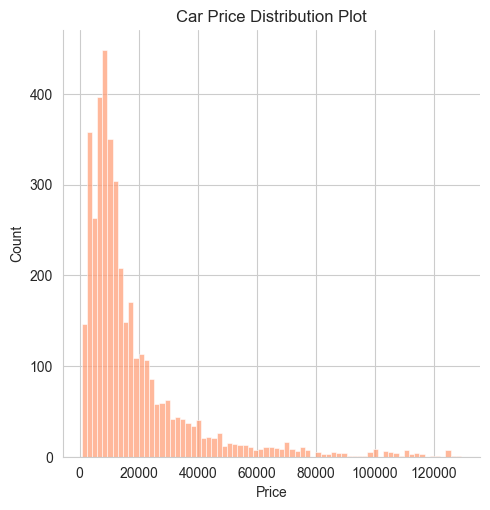

In [868]:
plt.figure(figsize=[11,5])
sns.displot(df_1['Price'])
plt.title('Car Price Distribution Plot')

Wzorce w danych są dość wykładnicze w tym stanie, a transformacja logarytmiczna jest powszechnym sposobem radzenia sobie z tym problemem. Transformacja logarytmiczna jest szczególnie przydatna w przypadku wykresów rozrzutu wykładniczego, takich jak te, które teraz mamy. Transformacja logarytmiczna może być użyta do uczynienia związku między zmiennymi bardziej liniowym, co ułatwia modelowanie i interpretację danych.

### Tranformacja log

In [869]:
# Tranformacja log dla "Price"
log_price = np.log(df_main['Price'])

df_main['log_price'] = log_price
df_main.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,log_price
0,BMW,4200.00,sedan,277,2.00,Petrol,yes,1991,8.34
1,Mercedes-Benz,7900.00,van,427,2.90,Diesel,yes,1999,8.97
2,Mercedes-Benz,13300.00,sedan,358,5.00,Gas,yes,2003,9.50
3,Audi,23000.00,crossover,240,4.20,Petrol,yes,2007,10.04
4,Toyota,18300.00,crossover,120,2.00,Petrol,yes,2011,9.81


Text(0.5, 1.0, 'Log price and EngineV')

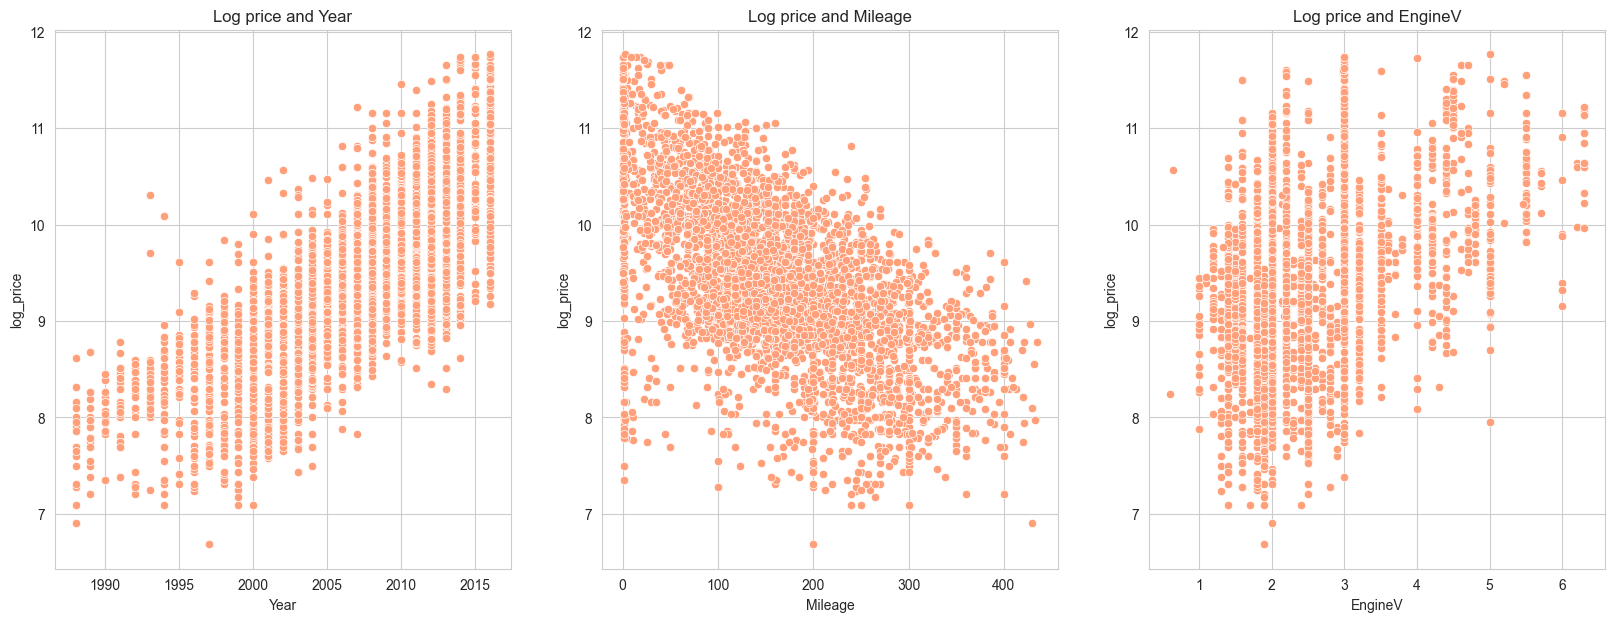

In [870]:
# Sprawdzmy teraz jeszcze raz te trzy wykresy Scaatterplot

plt.figure(figsize=[20,7])
plt.subplot(1,3,1)
plt.title("Log price and Year")
sns.scatterplot(x='Year',y='log_price',data=df_main)

plt.subplot(1,3,2)
plt.title("Log price and Mileage")
sns.scatterplot(y='log_price',x='Mileage',data=df_main)

plt.subplot(1,3,3)
sns.scatterplot(y='log_price',x='EngineV',data=df_main)
plt.title("Log price and EngineV")

Relacje wskazują na wyraźną liniową zależność.
To dobry materiał do analizy regresji liniowej.

In [871]:
# Usuwany starą kolumnę
df_main = df_main.drop(['Price'],axis=1)

---

### Sprawdzanie współliniowości za pomocą VIF

In [872]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = df_main[['Mileage','Year','EngineV']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
vif

,VIF,Features
0,3.79,Mileage
1,10.35,Year
2,7.66,EngineV


'Rok' ma wysoki współczynnik VIF, dlatego po prostu go usuwamy.
Więc nawet jeśli EngineV wydaje się mieć wysoki VIF, po usunięciu 'Roku' już tak nie będzie.

In [873]:
data_no_multicolinearity = df_main.drop('Year',axis=1)

In [874]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = data_no_multicolinearity[['Mileage', 'EngineV']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
vif

,VIF,Features
0,2.81,Mileage
1,2.81,EngineV


In [875]:
data_no_multicolinearity.head()

,Brand,Body,Mileage,EngineV,Engine Type,Registration,log_price
0,BMW,sedan,277,2.00,Petrol,yes,8.34
1,Mercedes-Benz,van,427,2.90,Diesel,yes,8.97
2,Mercedes-Benz,sedan,358,5.00,Gas,yes,9.50
3,Audi,crossover,240,4.20,Petrol,yes,10.04
4,Toyota,crossover,120,2.00,Petrol,yes,9.81


---

# Selekcja cech

Selekcji cech ma na celu uproszczenie modelu, poprawienie jego szybkości działania oraz zapobieganie problemom, które mogą pojawić się przy posiadaniu zbyt wielu cech. Selekcja cech polega na wyborze tylko tych, które mają największy wpływ na predykcję. Pozwala to na zwiększenie jakości modelu i zmniejszenie złożoności obliczeniowej.

In [876]:
from sklearn.preprocessing import LabelEncoder
temp_data = data_no_multicolinearity.copy()
for col in temp_data.columns:
    if temp_data[col].dtypes == 'object':
        encoder = LabelEncoder()
        temp_data[col] = encoder.fit_transform(temp_data[col])
        
# Wyświetlenie zmiennych skorelowanych z log_price
print('\n--Correated Features with target variable--\n')
print(abs(temp_data.corrwith(temp_data['log_price'])).sort_values(ascending=False)[1:])


--Correated Features with target variable--

Mileage        0.61
Registration   0.46
EngineV        0.41
Body           0.39
Brand          0.10
Engine Type    0.01
dtype: float64


W przedstawionym wyniku widzimy, że cechy Mileage i Registration są silnie skorelowane z log_price (odpowiednio 0.61 i 0.46), natomiast cechy Engine Type i Brand nie są skorelowane z log_price (odpowiednio 0.01 i 0.1)

<AxesSubplot:>

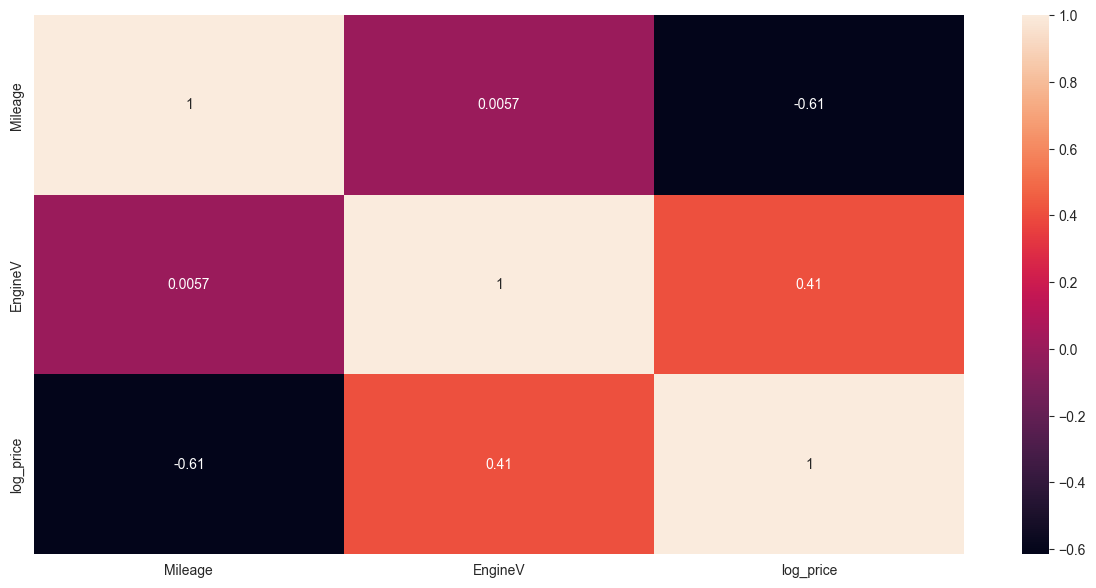

In [877]:
# Tworzymy mapę korelacji
plt.figure(figsize=[15,7])
sns.heatmap(data_no_multicolinearity.corr(), annot=True)

In [878]:
# Wyznaczanie ważnych zmiennych za pomocą ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor
X = temp_data.drop('log_price',axis=1)
y = temp_data['log_price']
model = ExtraTreesRegressor()
model.fit(X,y)

ExtraTreesRegressor()

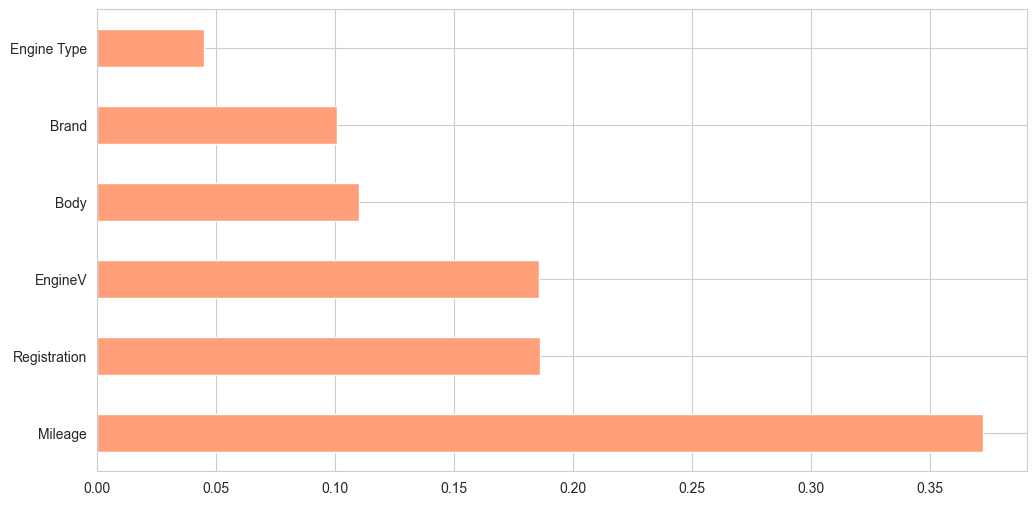

In [879]:
# Wykres ważności zmiennych
plt.figure(figsize=[12,6])
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(6).plot(kind='barh')
plt.show()

In [880]:
print(feat_importances.sort_values(ascending=False))

Mileage        0.37
Registration   0.19
EngineV        0.19
Body           0.11
Brand          0.10
Engine Type    0.05
dtype: float64


Ten wynik przedstawia wartości ważności poszczególnych cech (kolumn danych) dla modelu ExtraTreesRegressor. W przedstawionym wyniku widzimy, że cechy Mileage, EngineV, Registration ponownie mają największą ważność. 

## Zmienne kategoryczne

In [881]:
# Tworzymy zmienne kategoryczne
data_with_dummies = pd.get_dummies(data_no_multicolinearity,drop_first=True)

In [882]:
data_with_dummies.head()

,Mileage,EngineV,log_price,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,277,2.00,8.34,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,427,2.90,8.97,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,358,5.00,9.50,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,240,4.20,10.04,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,120,2.00,9.81,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


# Tworzenie modelu

### Przypisanie zmiennych X i y

In [883]:
x = data_with_dummies.drop('log_price',axis=1)
y = data_with_dummies['log_price']

### Standaryzacja

In [884]:
# Ostatecznie wybieramy cechy Mileage i EngineV
# Standaryzacja zmiennych Mileage i EngineV
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x[['Mileage','EngineV']])

StandardScaler()

In [885]:
inputs_scaled = scaler.transform(x[['Mileage','EngineV']])
scaled_data = pd.DataFrame(inputs_scaled,columns=['Mileage','EngineV'])

In [886]:
input_scaled2 =scaled_data.join(x.drop(['Mileage','EngineV'],axis=1))

In [887]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(input_scaled2,y,test_size=0.2, random_state=42)

# Support Vector Machine (SVM):

In [888]:
# Tworzymy obiekt klasy SVR
from sklearn.svm import SVR
svm = SVR()

# Uczymy model na danych treningowych
svm.fit(x_train,y_train)

# Przewidujemy wartości dla danych testowych
y_pred_svm = svm.predict(x_test)

#Obliczamy wartości współczynników R^2 i RMSE dla modelu
r_squared = r2_score(y_test,y_pred_svm)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_svm))
print("R_squared :",r_squared)
print("RMSE :",rmse)

R_squared : 0.7394980078093978
RMSE : 0.46335983670743514


R_squared jest miarą dopasowania modelu do danych. Im jest on bliżej 1, tym lepiej model odpowiada danym. W tym przypadku R_squared wynosi 0.739498, co oznacza, że model jest dobrze dopasowany do danych.

RMSE (Root Mean Squared Error) jest miarą średniego kwadratowego błędu między wartościami rzeczywistymi a przewidywanymi. Im mniejszy jest RMSE, tym lepiej model przewiduje dane. W tym przypadku RMSE wynosi 0.46336, co oznacza, że model ma niski błąd przewidywania.

# K-Nearest Neighbors (KNN):

In [889]:
# Model Building
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()

# Training Model
knn.fit(x_train,y_train)

# Model Summary
y_pred_knn = knn.predict(x_test)

r_squared = r2_score(y_test,y_pred_knn)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_knn))
print("R_squared :",r_squared)
print("RMSE :",rmse)

R_squared : 0.701167536002242
RMSE : 0.4962799737198071


W tym przypadku R_squared wynosi 0.701168, co oznacza, że model jest dobrze dopasowany do danych, ale nie tak dobrze jak poprzedni model. 

RMSE wynosi 0.49628, co oznacza, że model ma średni błąd przewidywania, jest on większy niż poprzedni model.

# Linear Regression 

In [890]:
# Model Building
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

# Training Model
lr.fit(x_train,y_train)

# Model Summary
y_pred_lr = lr.predict(x_test)

r_squared = r2_score(y_test,y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_lr))
print("R_squared :",r_squared)
print("RMSE :",rmse)

R_squared : 0.7352752333232253
RMSE : 0.46710030382214934


W tym przypadku R_squared wynosi 0.73527, co oznacza, że model jest dobrze dopasowany do danych. 

RMSE wynosi 0.4671, co oznacza, że model ma średni błąd przewidywania.

# Decision Tree

In [891]:
# Model Building
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()

# Training Model
dt.fit(x_train,y_train)

# Model Summary
y_pred_dt = dt.predict(x_test)

r_squared = r2_score(y_test,y_pred_dt)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_dt))
print("R_squared :",r_squared)
print("RMSE :",rmse)

R_squared : 0.6264693297525247
RMSE : 0.5548505185254171


W tym przypadku R_squared wynosi 0.6401, co oznacza, że model jest słabo dopasowany do danych i nie jest dobrym modelem do przewidywania. 

RMSE wynosi 0.5446, co oznacza, że model ma duży błąd przewidywania i nie jest dobrym modelem do przewidywania.

# Random Forest

In [892]:
# Model Building
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

# Training Model
rf.fit(x_train,y_train)

# Model Summary
y_pred_rf = rf.predict(x_test)

r_squared = r2_score(y_test,y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_rf))
print("R_squared :",r_squared)
print("RMSE :",rmse)

R_squared : 0.773336669008098
RMSE : 0.4322186435656639


W tym przypadku R_squared wynosi 0.7722, co oznacza, że model jest dobrze dopasowany do danych i jest dobrym modelem do przewidywania.

RMSE wynosi 0.4333, co oznacza, że model ma niski błąd przewidywania i jest dobrym modelem do przewidywania.


# GBT Regressor

In [893]:
from sklearn.ensemble import GradientBoostingRegressor
gbt = GradientBoostingRegressor()

gbt.fit(x_train,y_train)

y_pred_gbt = gbt.predict(x_test)

r_squared = r2_score(y_test,y_pred_gbt)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_gbt))
print("R_squared :",r_squared)
print("RMSE :",rmse)

R_squared : 0.7707622827885842
RMSE : 0.4346662298030787


 W tym przypadku R_squared wynosi 0.7709, co oznacza, że model jest dobrze dopasowany do danych i jest dobrym modelem do przewidywania.

 RMSE wynosi 0.4345, co oznacza, że model ma niski błąd przewidywania i jest dobrym modelem do przewidywania.



# Wybór najlepszego modelu

In [894]:
# Lista modeli
models = [('Linear Regression', LinearRegression()), 
          ('Random Forest Regressor', RandomForestRegressor()), 
          ('GBT Regressor', GradientBoostingRegressor()),
          ('Support Vector Machine Regressor', SVR()),
          ('K-Nearest Neighbors Regressor', KNeighborsRegressor()),
          ('Decision Tree Regressor', DecisionTreeRegressor())]

# Dataframe do przechowywania wyników
results = pd.DataFrame(columns=['Model','R_squared','RMSE'])

# Trenowanie i predykcja
for name, model in models:
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    r_squared = r2_score(y_test,y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    results = results.append({'Model':name, 'R_squared':r_squared, 'RMSE':rmse}, ignore_index=True)

# Wyświetlenie wyników
print(results)

                              Model  R_squared  RMSE
0                 Linear Regression       0.74  0.47
1           Random Forest Regressor       0.78  0.43
2                     GBT Regressor       0.77  0.43
3  Support Vector Machine Regressor       0.74  0.46
4     K-Nearest Neighbors Regressor       0.70  0.50
5           Decision Tree Regressor       0.63  0.55


Wyniki pokazują, że najlepszym modelem jest Random Forest Regressor, ponieważ ma najwyższy współczynnik R_squared (0.7721) i najniższy RMSE (0.4333).

# Sprawdzenie predykcji "ręcznie"

In [895]:
df_ev = pd.DataFrame(np.exp(y_pred_rf), columns=['Predicted Price'])

y_test = y_test.reset_index(drop=True)
df_ev['Actual Price'] = np.exp(y_test)

df_ev['Residual'] = df_ev['Actual Price'] - df_ev['Predicted Price']
df_ev['Difference%'] = np.absolute(df_ev['Residual']/df_ev['Actual Price']*100)

pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_ev.sort_values(by=['Difference%'])

df_ev.tail(10)

,Predicted Price,Actual Price,Residual,Difference%
764,18631.02,27000.00,8368.98,31.00
765,6800.38,6800.00,-0.38,0.01
766,11740.38,13499.00,1758.62,13.03
767,9897.52,8000.00,-1897.52,23.72
768,28152.19,27300.00,-852.19,3.12
769,3683.26,4200.00,516.74,12.30
770,5210.38,8800.00,3589.62,40.79
771,5443.03,4850.00,-593.03,12.23
772,19564.84,27000.00,7435.16,27.54
773,9681.55,10900.00,1218.45,11.18


Wyniki prezentowane w tabeli przedstawiają porównanie cen rzeczywistych z cenami przewidywanymi dla ostatnich 10 elementów zestawu danych testowych. Kolumny "Predicted Price" i "Actual Price" przedstawiają odpowiednio przewidywane i rzeczywiste ceny, kolumna "Residual" przedstawia różnicę między cenami a "Difference%" przedstawia procentowy udział różnicy między cenami.
Z danych wynika, że model przewiduje ceny z pewnym błędem, co jest widoczne po wartościach w kolumnie "Difference%", które wahają się od 0,01% do 40,79%. Największe błędy dotyczą elementów o nr 770 i 773, gdzie różnica między cenami przewidywanymi a rzeczywistymi wynosi odpowiednio 40,79% i 11,18%.

---
### Podsumowanie

W ramach tego projektu przeprowadzono analizę wpływu różnych czynników na cenę samochodów używanych. Dla celów tego projektu zastosowano kilka różnych metod regresji, takich jak: regresja liniowa, drzewo decyzyjne, las losowy, regresja gradient boosting, SVM oraz KNN. Modele te zostały zastosowane do przewidywania cen samochodów na podstawie dostępnych danych dotyczących m.in. roku produkcji, pojemności silnika, przebiegu, marki i modelu oraz ilości właścicieli.

Ocena każdego z modeli została przeprowadzona za pomocą współczynnika R^2 oraz RMSE. Okazało się, że najlepszym modelem jest Random Forest Regressor, który uzyskał najwyższy współczynnik R^2 (0.7721) oraz najniższe RMSE (0.4333). To pokazuje, że ta metoda jest najlepsza w przewidywaniu cen samochodów na podstawie danych zawartych w zbiorze danych. Warto jednak zauważyć, że różnica między najlepszym modelem, a modelem kolejnym nie jest znacząca.

Aby zweryfikować dokładność przewidywań, zaprezentowano również dane dotyczące różnicy między przewidywaną ceną a rzeczywistą ceną oraz procentowym udziałem różnicy między cenami.

---

---